# Conformal prediction for regression

In [111]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.base import clone

from mapie.regression import MapieRegressor

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

In [112]:
# paramters that can be tweaked
random_state = 42
np.random.seed(random_state)
epsilon = 0.05
mu, sigma, n_samples, noise = 0, 5, 500, 1

# Used for plotting the target function
X_general = np.arange(mu - 3*sigma, mu + 3*sigma, step = sigma/20)
norm_quantile = sps.norm.ppf(1 - epsilon) 


##### Jupyter Book auxiliary########
from myst_nb import glue
glue("mu",mu, display=False) # makes the vairble mu abailable in markdown cell with {glue:}`mu`
glue("sigma",sigma, display=False)
glue("noise", noise, display=False)
###################################



def are_both_intervals_equal(interval1,interval2):
    print("Are both inervals equal?")
    if np.all(interval1 == interval2):
        print("Yes, both are equal!")
    else:
        print("No, both are not equal!")

def calculate_quantile(scores, epsilon, method="higher", axis=0):
    if len(scores.shape) == 1:
        n, = scores.shape
    else:
        _,n = scores.shape
    return np.quantile(
        scores,
        axis=axis,
        q=((n + 1) * (1 - epsilon)) / n,
        method=method,
    )

def target_function(X):
    return X * np.sin(X) * np.cos(X)

def create_regression_data(mu,sigma, n_samples, noise):
    X_train = np.random.normal(mu,sigma,n_samples).reshape(-1,1)
    X_test = np.arange(mu - 2.5*sigma, mu + 2.5*sigma, sigma/10).reshape(-1,1)
    
    y_train = target_function(X_train) + np.random.normal(0,
                                                          noise,
                                                          X_train.shape[0])[:,None]
    y_test = target_function(X_test) + np.random.normal(0,
                                                        noise,
                                                        X_test.shape[0])[:,None]

    return (
        X_train,
        X_test,
        y_train.ravel(),
        y_test.ravel()
    )
    
def get_coverage(true_ground, interval):
    coverage = 0
    for i, inter in enumerate(interval):
        current_value = true_ground[i]
        coverage += inter[0] <= current_value <= inter[1]
    coverage = coverage / len(true_ground)
    return coverage

def plot_data(
    X_train,
    X_test,
    y_train,
    y_test,
    y_pred=None,              
    y_pred_interval=None,
    method=None):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(w=12,h=5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    # plot the true relationship with confidence intervals
    ax.plot(
        X_general, target_function(X_general), color="gray", ls="-", label="ground_truth"
    )
    ax.plot(X_general, target_function(X_general) - norm_quantile * noise, color="gray", ls="--", label="95% confidence interval of ground_truth")
    ax.plot(X_general, target_function(X_general) + norm_quantile * noise, color="gray", ls="--")

    if y_pred is not None and y_pred_interval is not None:
        # plot the prediction plus the interval
        ax.scatter(X_test,y_pred,color="aqua", label="prediction")
        ax.fill_between(X_test.ravel(), y_pred_interval[:,0].ravel(), y_pred_interval[:,1].ravel(), alpha=.4, label="prediction_coverage")

    # plot the data points
    ax.scatter(X_train, y_train, color="green", label="train data", alpha=.3)
    ax.scatter(X_test, y_test, color="red", label="test data")

    # set title
    if method != None:
        ax.set_title(f"Visualization of \"{method}\" having coverage = {round(get_coverage(y_test,y_pred_interval),2)}")
    else:
        ax.set_title(f"Visualization of data")
    ax.legend(loc="lower center")
    
    plt.show()

We now discuss Conformal prediction applied to regression tasks. We recommend reading the Chapter on Conformal Classification (Section ....) as it covers the general idea. Regression is done through inductive conformal prediction which can be briefly described in four steps:

1. Given $1, \dots, k$ data points fit machine learning algorithm resulting in model $\hat{h}$.
2. Train a arbitrary machine learning model on the training set
3. Calculate the non-conformity scores for the calibration set
4. Use these value to create a prediction interval for each new observation.

The non-conformity function $f$ can be seen as the ''weirdness' of a label $y$ given the features $x$.
For the non-conformity function $f$ we use the *absolute residual score* one of the most commonly used non-conformity score functions:

$$
    f_h(x,y) = | y - h(x) |
$$

where $h$ is the underlying machine learning model we use.\

In [113]:
def absolute_residual_score(model,X,y):
    return np.abs(y - model.predict(X))

There are different ways of constructing the non-conformity scores namely *Split*, *Jackknife*, *Jackknife+* which we will present. \
We apply these methods to synthetic data, with features X being drawn from a Gaussian distribution with parameters $\mu = $ {glue:}`mu`, $\sigma=$ {glue:}`sigma`.
The relationship between the X values and target y is described by the function $x \mapsto x\sin(x)\cos(x)$.
Noise was added to y drawn from Gaussian distribution with $\mu=0$ and $\sigma=${glue:}`noise`.

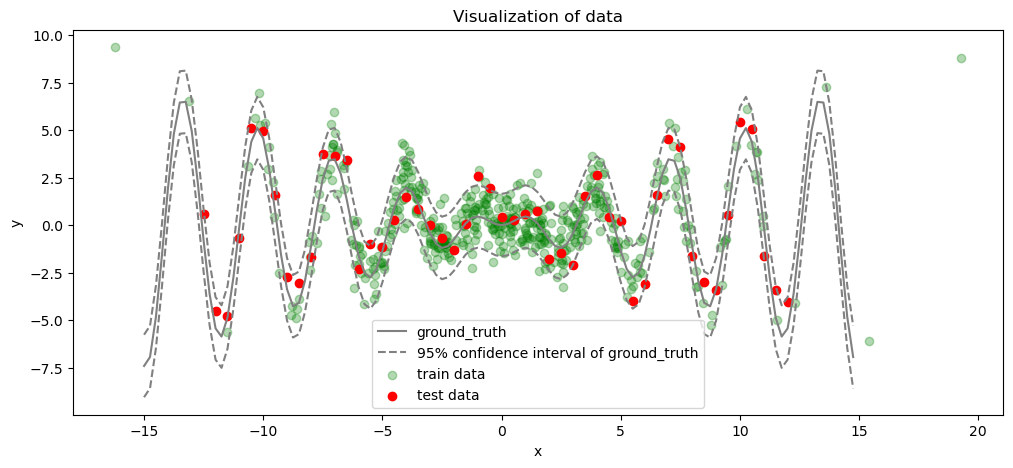

In [114]:
X_train,X_test,y_train,y_test = create_regression_data(mu,
                                                       sigma,
                                                       n_samples,
                                                       noise)
plot_data(X_train,X_test,y_train,y_test)

(content:split)=
## Split Method
This method acts identically to the presented method in the setting of classification (Section (....) ).
It can be described by the following steps

1. Split the training data into a $k$ training and $l$ validation points and fit a model $\hat{h}$ on the training data.
2. Given $i = k+1, \dots, k+l$ calibration points apply calculate the non-conformity scores $\alpha_i = f_{\hat{h}}(y_i, x_i)$.
3. Calculate the Quantile $ q_{split} = \lceil (1-\epsilon)*(l+1)\rceil \text{-Quantile of the sequence }(\alpha_{l+1}, \, \alpha_{l+2}, \ldots , \alpha_{l+k})$ for a predefined significance level $\epsilon$.
4. Build the prediction interval $Y_\epsilon$ for a new data point $x_{N+1}$:
$$
    Y_\epsilon = [\hat{h}(X_{N+1} - q_{split} \ , \ \hat h(x_{N+1})  + q_{split})]
$$

Given the above data, we firstly split the training into train and validation data.

In [115]:
X_train_prefit,X_val,y_train_prefit,y_val = train_test_split(X_train,y_train,
                                               train_size=0.8,
                                               random_state=random_state)

In the next step we fit an arbitrary machine learning algorithm to the training data.
Here we will use the [GradienBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html).

In [116]:
base_model = GradientBoostingRegressor(
    loss="squared_error",
    random_state=random_state
)  # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html
base_model.fit(X_train_prefit, y_train_prefit)


GradientBoostingRegressor(random_state=42)

Then we apply the non-conformity function $f$ to the validation dataset.

In [117]:
# construct the sequence of residuals
split_non_conformity_scores = absolute_residual_score(model=base_model,X=X_val,y=y_val)
split_non_conformity_scores

array([ 2.36062943,  0.08059899,  0.76411628,  0.20657237,  0.15755717,
        1.11855537,  0.66539151,  1.34284972,  1.85045181,  0.20191175,
        1.51606508,  1.01941806,  2.03959684,  0.17828968,  1.26047158,
        1.00848296,  0.99080243,  0.80084621,  0.9567785 ,  0.87351914,
        0.15738364,  1.3922797 ,  0.3824036 ,  0.87642259,  0.34942551,
        1.30701361,  0.43187764,  0.87769807,  1.3142595 ,  0.35793386,
        1.80202036,  1.47939332,  1.46454116,  0.4695421 ,  1.26834369,
        1.17986034,  1.73382264,  0.04096636, 14.24465326,  0.56218391,
        0.47129199,  0.39860685,  1.49115445,  1.88057586,  1.77278326,
        0.66609913,  0.46298179,  0.68502159,  0.01913816,  0.60967767,
        0.30574642,  1.2381659 ,  1.58549219,  0.8271196 ,  1.00261591,
        0.45471511,  0.70724678,  0.02105587,  2.11552267,  1.34899324,
        1.52257053,  3.61659715,  1.1014292 ,  0.40616794,  1.7947362 ,
        0.12420681,  0.65688477,  0.04028658,  2.32792123,  0.04

Now we must calculate the $\lceil (1-\epsilon)*(l+1)\rceil$ Quantile on $\alpha_{l+1}, \, \alpha_{l+2}, \ldots , \alpha_{l+k}$.

In [118]:
split_quantile = calculate_quantile(split_non_conformity_scores,epsilon)
split_quantile

2.360629430988524

In [119]:
def output_mean_interval_width(intervals):
    interval_widths = intervals[:,1] - intervals[:,0]
    print("Mean interval width: ", np.mean(interval_widths))

def get_prediction_interval_through_quantile(predictions, quantile):
    
    prediction_lower = (predictions - quantile).reshape(-1,1)
    prediction_higher = (predictions + quantile).reshape(-1,1)

    prediction_interval = np.concatenate((prediction_lower,prediction_higher),axis=1)
    return predictions, prediction_interval



split_prediction, split_interval = get_prediction_interval_through_quantile(
    predictions=base_model.predict(X_test), 
    quantile=split_quantile
)
print(split_interval[:2])
output_mean_interval_width(split_interval)

[[ 3.38716021  8.10841907]
 [-6.48887224 -1.76761338]]
Mean interval width:  4.721258861977048


An equal approach is firstly adding/subtracting the non-conformity scores $\alpha_{l+1}, \, \alpha_{l+2}, \ldots , \alpha_{l+k}$ from the predictions and then computing the upper bound $q_{n,\epsilon}^+$ and $q_{n,\epsilon}^-$ which are calculated as follows:
$$
    q_{n,\epsilon}^{+}(v_i) = \lceil (1-\epsilon)*(n+1)\rceil \text{-Quantile of the sequence }(v_1, v_2, \ldots , v_n)
$$
$$
    q_{n,\epsilon}^{-}(v_i) = \lfloor \epsilon*(n+1)\rfloor \text{-Quantile of the sequence }(v_1, v_2, \ldots , v_n) = -q_{n,\epsilon}^{+}(-v_i)
$$

The corresponding prediction interval $Y_\epsilon$ for a new data point $x_{N+1}$ would then be:

$$
    Y_\epsilon = [q_{N,\epsilon}^{-}(\hat{h}(x_{N+1}) - \alpha_i), q_{N,\epsilon}^{+}(\hat{h}(x_{N+1}) + \alpha_i]
$$

In [120]:
def get_prediction_interval_through_scores(predictions, non_conformity_scores):
    if len(predictions.shape) == 1:
        plus_sequence = predictions[:, None] + non_conformity_scores[None, :]
        neg_sequence = predictions[:, None] - non_conformity_scores[None, :]
    else:
        # jackknife plus method
        plus_sequence = predictions + non_conformity_scores
        neg_sequence = predictions - non_conformity_scores

    prediction_higher = calculate_quantile(
        plus_sequence, epsilon, "higher", axis=1
    ).reshape(
        -1, 1
    )  # 1-epsilon quantile
    prediction_lower = calculate_quantile(
        neg_sequence, 1 - epsilon, "lower", axis=1
    ).reshape(
        -1, 1
    )  # epsilon quantile

    prediction_interval = np.concatenate((prediction_lower, prediction_higher), axis=1)
    return predictions, prediction_interval


split_prediction_2, split_interval_2 = get_prediction_interval_through_scores(
    base_model.predict(X_test), split_non_conformity_scores
)
print(split_interval_2[:2])
output_mean_interval_width(split_interval_2)

[[ 3.38716021  8.10841907]
 [-6.48887224 -1.76761338]]
Mean interval width:  4.721258861977048


Reproducing the above intervals with the [MapieRegressor](https://mapie.readthedocs.io/en/latest/generated/mapie.regression.MapieRegressor.html#mapie.regression.MapieRegressor). \
`methdo="base"` tells MAPIE, when constructing the prediction interval to apply the non-conformity function to the calibration dataset.\
`cv="prefit"` indicates that the `estimator` has already been fitted to the data.

In [121]:
conformal_model = MapieRegressor(
    estimator=base_model, method="base", cv="prefit", random_state=random_state
)
conformal_model.fit(X_val, y_val)
y_pred_split_prefit, y_interval_split_prefit = conformal_model.predict(X_test,
                                             alpha=epsilon)
y_interval_split_prefit = y_interval_split_prefit.reshape(-1, 2)
print(y_interval_split_prefit[:2])
output_mean_interval_width(y_interval_split_prefit)

[[ 3.38716021  8.10841907]
 [-6.48887224 -1.76761338]]
Mean interval width:  4.721258861977048


```{note}
    The MAPIE package supports predicting the intervals with multiple alpha/epsilon values. \
    Because we are only using one alpha/epsilon value we can safely apply `y_interval_split_prefit.reshape(-1, 2)`. \
    When using multiple values this is not recommended!
```

## Split Method without Prefit
Instead of manually splitting the training data into train and calibration data, MAPIE can do for us.
To achieve the same result we use the `cv = "split"`parameter.
More on the cv parameter can be found in the [documentation](https://mapie.readthedocs.io/en/latest/generated/mapie.regression.MapieRegressor.html#mapie.regression.MapieRegressor).

In [122]:
conformel_model = MapieRegressor(
    estimator=clone(base_model),
    method="base",
    cv="split", 
    test_size=0.2,
    random_state=random_state
)

conformel_model.fit(X_train, y_train)
y_pred_split, y_interval_split = conformel_model.predict(X_test, alpha=0.05)
y_interval_split = y_interval_split.reshape(-1, 2)

print(y_interval_split[:2])
output_mean_interval_width(y_interval_split)

[[ 3.38716021  8.10841907]
 [-6.48887224 -1.76761338]]
Mean interval width:  4.721258861977048


/Users/santothies/miniforge3/envs/kaggle2/lib/python3.12/site-packages/mapie/utils.py:542: UserWarning: WARNING: at least one point of training set belongs to every resamplings.
Increase the number of resamplings
  warnings.warn(
/Users/santothies/miniforge3/envs/kaggle2/lib/python3.12/site-packages/mapie/aggregation_functions.py:118: RuntimeWarning: Mean of empty slice
  return np.nanmean(X, axis=1)


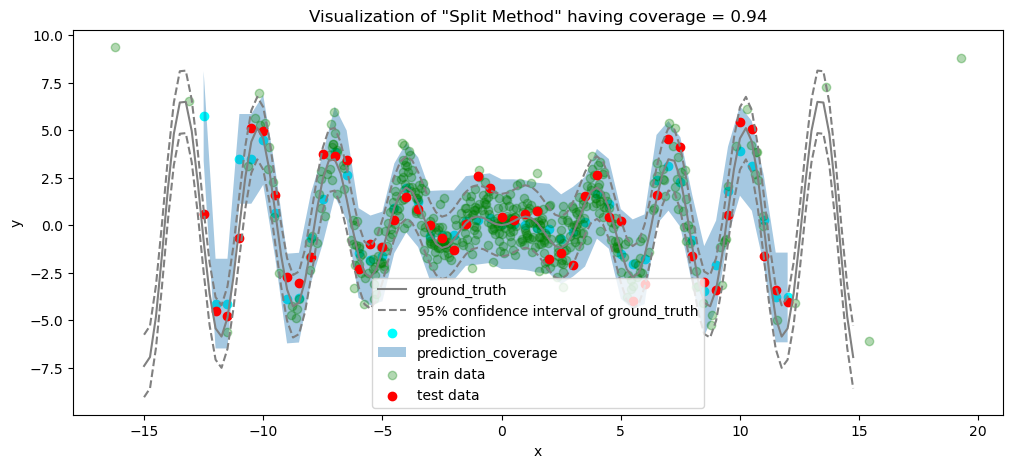

In [123]:
plot_data(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    y_pred=y_pred_split,
    y_pred_interval=y_interval_split,
    method="Split Method"
)

(content:jackknife)=
## Jackknife Method
Instead of only using one calibration split to compute $l$ non-conformity scores as in the *Split Method* {ref}`split`, the Jackknife (or Leave-one-out) computes $l+k$ values.
It consists of the following four steps:
1. For each training instance $i = 1, \dots, l+k$ fit a model $\hat{h}_{-i}$ on all data points excluding i.
2. Given $i =1, \dots, l+k$ models $\hat{h}_{-i}$ the non-conformity scores are computed: $\alpha_i^{jack} = f_{\hat{h}_{-i}}(y_i,x_i)$.
3. Based on these scores $\alpha_1^{jack}, \dots, \alpha_{l+k}^{jack}$ the corresponding quantile $ q_{jack} =\lceil (1-\epsilon)*(l+k+1)\rceil \text{-quantile of the sequence }(\alpha_{1}^{jack}, \, \alpha_{l+2}^{jack}, \ldots , \alpha_{l+k}^{jack})$ is calculated.
4. The prediction interval for a new instance $x_{N+1}$ is calculated through $\pm \ q_{jack}$:
$$
    [\hat{h}(x_{N+1}) - q_{jack} , \hat{h}(x_{N+1}) + q_{jack}]
$$
where $\hat{h}$ is the model trained on all $l+k$ data points.

Let us start with fitting the corresponding models $\hat{h}_{-i}$ for all $i = 1, \dots, l+k$.
Doing this we can directly compute the corresponding $\alpha_i^{jack} = f_{\hat{h}_{-i}}(y_i,x_i)$.

In [124]:
model_missing_data = []
jackknife_non_conformity_scores = [0] * len(X_train)

# 1: Fit the \hat h_{-i} models on the training data
for i in range(len(X_train)):
    new_model = clone(base_model)
    
    X_train_missing_i, y_train_missing_i = np.delete(X_train, i, axis=0), np.delete(
        y_train, i, axis=0
    )
    new_model.fit(X_train_missing_i, y_train_missing_i)
    # 2: calculate non-conformity scores
    jackknife_non_conformity_scores[i] = np.abs(y_train[i] - new_model.predict(
        X_train[i].reshape(1, -1)
    ))
    model_missing_data.append(new_model)

jackknife_non_conformity_scores = np.array(jackknife_non_conformity_scores).ravel()

As for the next step we calculate the $\lceil (1-\epsilon)*(l+k+1)\rceil$-quantile of `jackknife_non_conformity_scores`.

In [ ]:
# 3: Compute quantile
jackknife_quantile = calculate_quantile(jackknife_non_conformity_scores, epsilon)
jackknife_quantile

2.3036399728978294

In the last step we train our model $\hat{h}$ on the entire $l+k$ data points. 
For a new data points $x_{N+1}$ the prediction interval $Y_\epsilon$ is computed by subtracting and adding the Quantile `jackknife_quantile` to $\hat{h}(x_{N+1})$.

In [ ]:
# 4: Get prediction intervals
jackknife_model = clone(base_model)  # done such that upper cells do not interfere here
jackknife_model.fit(X_train, y_train)

jackknife_prediction, jackknife_interval = get_prediction_interval_through_quantile(
    jackknife_model.predict(X_test), jackknife_quantile
)
print(jackknife_interval[:2])
output_mean_interval_width(jackknife_interval)

[[ 3.89881798  8.50609793]
 [-6.03573977 -1.42845983]]
Mean interval width:  4.607279945795659


Again as above in *Split*(see Section {ref}`split`) we can firstly add the `jackknife_non_conformity_scores` to the prediction $\hat{h(x_{N+1})}$ and then take the corresponding Quantiles as bounds.
$$
    Y_\epsilon = [ q_{n,\epsilon}^{-}(\hat{h}(x_{N+1}) - \alpha_i^{jack}) \ , \ q_{n,\epsilon}^{+}(\hat{h}(x_{N+1}) + \alpha_i^{jack})]
$$

In [ ]:
# 4
jackknife_model = clone(base_model)  # done such that upper cells do not interfere here
jackknife_model.fit(X_train, y_train)

jackknife_prediction_2, jackknife_interval_2 = get_prediction_interval_through_scores(
    jackknife_model.predict(X_test), jackknife_non_conformity_scores
)
print(jackknife_interval_2[:2])
output_mean_interval_width(jackknife_interval_2)

[[ 3.89881798  8.50609793]
 [-6.03573977 -1.42845983]]
Mean interval width:  4.607279945795659


```{warning}
In most common cases the coverage of the jackknife method is equal to $1-\epsilon$.
But in scenarios where a regression model is less stable (samples size equal to number of features) the coverage might be less than $1-\epsilon$. For further details see {cite:t}`Barber2019PredictiveIW`.

```

Equally in MAPIE:

In [ ]:
conformel_model = MapieRegressor(
    estimator=base_model, method="base", cv=-1, random_state=random_state
)
conformel_model.fit(X_train, y_train)

y_pred_jackknife, y_interval_jackknife = conformel_model.predict(X_test, alpha=epsilon)
y_interval_jackknife = y_interval_jackknife.reshape(-1, 2)

print(y_interval_jackknife[:2])
output_mean_interval_width(y_interval_jackknife)

[[ 3.89881798  8.50609793]
 [-6.03573977 -1.42845983]]
Mean interval width:  4.607279945795659


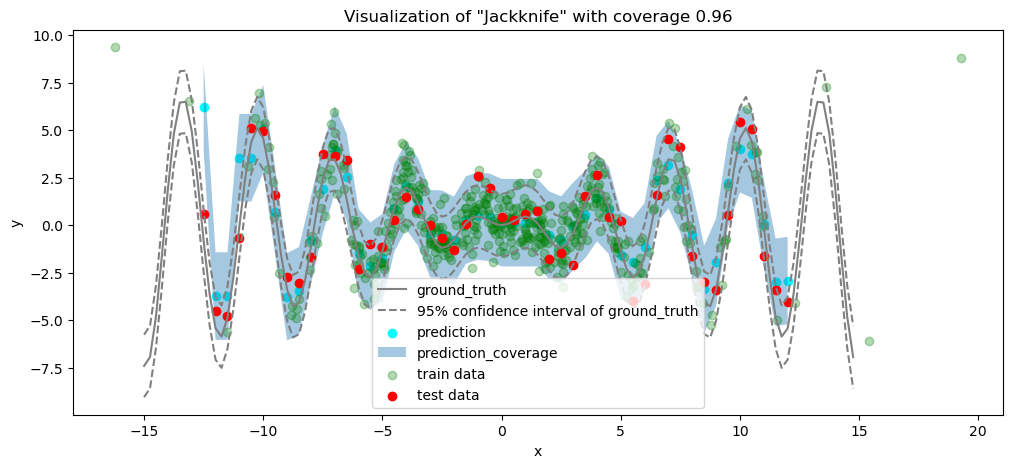

In [ ]:
plot_data(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    y_pred=y_pred_jackknife,
    y_pred_interval=y_interval_jackknife,
    method="Jackknife"
)

## Jackknife+ Method
In Jackknife we build the intervals based on $\hat{h}(x_{N+1})$ and the non-conformity scores $\alpha_i^{jack}$.
As seen in our example it perform better than just using one split, but no theoretical guarantee on the coverage can be given (see {cite}`Barber2019PredictiveIW`).
We now introduce the Jackknife+ method proposed by {cite:t}`Barber2019PredictiveIW`. \
The prediction of $x_{N+1}$ is not only based on $\hat h$ but rather on multiple predictions $\hat{h}_{-1}, \dots , \hat{h}_{-N}$, incorporating the variability of the underlying machine learning algorithm.
Jackknife+ guarantees a coverage of at least $1-2\epsilon$ while not having any assumptions than exchangeablility.
We again distinguish four steps:
1. For each training instance $i = 1, \dots, l+k$ fit a model $\hat{h}_{-i}$ on all data points excluding i.
2. Given $i =1, \dots, l+k$ models $\hat{h}_{-i}$ the non-conformity scores are computed: $\alpha_i = y_i - \hat{h}_{-i}$.
3. Based on these scores $\alpha_1, \dots, \alpha_{l+k}$ the corresponding quantile $ q_{jack} =\lceil (1-\epsilon)*(l+k+1)\rceil \text{-quantile of the sequence }(\alpha_{1}, \, \alpha_{l+2}, \ldots , \alpha_{l+k})$ is calculated.
4. The prediction interval for a new instance $x_{N+1}$ is calculated through :
$$
    [q_{l+k,\epsilon}^{-}\left(\hat{h}_{-i}(x_{N+1}) - \alpha_i \right) , q_{l+k,\epsilon}^{+}\left(\hat{h}_{-i}(x_{N+1}) + \alpha_i \right) ]
$$


In [ ]:
# 1: this is done above in jackknife
model_missing_data
# 2: see above in jackknife
jackknife_non_conformity_scores
# 3:
# get all predictions of the models \hat h_{-i}
missing_model_test_predictions = np.array([
    t.predict(X_test) for t in model_missing_data
]).T

# 4: build interval
jackknife_plus_prediction, jackknife_plus_interval = (
    get_prediction_interval_through_scores(
        missing_model_test_predictions, jackknife_non_conformity_scores
    )
)
print(jackknife_plus_interval[:2])
output_mean_interval_width(jackknife_plus_interval)

[[ 3.87031892  8.48400896]
 [-6.36664416 -1.59712437]]
Mean interval width:  4.655773126028885


In [ ]:
mapie_jackknife_plus = MapieRegressor(
    estimator=base_model, method="plus", cv=-1, random_state=random_state
)
mapie_jackknife_plus.fit(X_train, y_train)

y_pred_jackknife_plus, y_interval_jackknife_plus = mapie_jackknife_plus.predict(X_test, alpha=epsilon)
y_interval_jackknife_plus = y_interval_jackknife_plus.reshape(-1, 2)

print(y_interval_jackknife_plus[:2])
output_mean_interval_width(y_interval_jackknife_plus)

[[ 3.87031892  8.48400896]
 [-6.36664416 -1.59712437]]
Mean interval width:  4.655773126028885


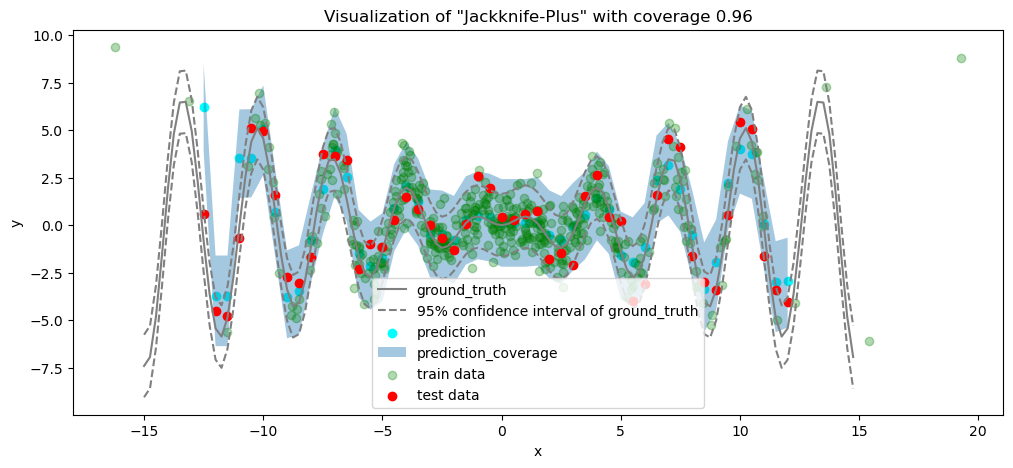

In [ ]:
plot_data(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    y_pred=y_pred_jackknife_plus,
    y_pred_interval=y_interval_jackknife_plus,
    method="Jackknife-Plus"
)